<a href="https://colab.research.google.com/github/MartinaMoglioni/CMEPDA-Project/blob/main/model_cnn/model_cnn_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolution Neural Network for classifying the images obtained from the brain MRIs of a cohort of subjects with Alzheimer’s disease and control subjects.

The hippocampus is one of the first affected brain regions in Alzheimer’s disease (AD), through MRI (Magnetic Resonance Imaging) is possible to measure the shape and the volume of the hippocampus, helping in early-stage diagnosis for prevention and intervention of the disease progression. 

In this code is proposed a multi-model deep learning framework based on a 3D CNN working on a parallelepiped - of 104x123x99 shape - contouring the brain.


#Introduction

The biggest problem with classifying the MRI images with some neural networks lies in the number of images in the database. In addition, MRI images are acquired in different planes, so the option of using all the available planes could enlarge the database. 
As this could generally affect the classification output by overfitting, pre-processing is required before feeding the images into the neural network.

However, one of the known advantages of convolutional neural networks (CNN) is that the pre-processing and the feature engineering aren't necessary.

The aim of this code is to examine the classification of two subjects types (CTRL, AD) from an MRI database with a 3DCNN. 

For volumetric 3D medical image, the effectiveness of conventional 2D CNNs are reduced due to loss of spatial information. To overcome the obstacles, a 3D CNN that implements the convolution and pooling processes is used. The 3D CNN takes hierarchical 3D image information by dividing it into small cubes instead of taking 2D patches, to capture discriminative features along the spatial dimensions. 

The network performance was tested using the dataset made available at: https://drive.google.com/drive/u/1/folders/1KfFF_ww-MW9z1B-pGaa-qBtSpfy-ckUJ

**Dataset**: 
The dataset contains the segmented grey matter (GM) of 189 healthy subjects (*CTRL_s3* folder) and 144 subjects affected by Alzheimer's Disease (*AD_s3 folder*).

All dataset details are provided in the reference paper:
Retico et al, Predictive Models Based on Support Vector Machines: Whole-Brain versus regional Analysis of Structural MRI in the Alzheimer's Disease. J Neuroimaging. 2015.

The available GM segmentation for each subjects are the smwc1* files generated by the SPM segmentation software (https://www.fil.ion.ucl.ac.uk/spm/).


The AD_CTRL_metadata.csv files contains for each subject:
- ID, the subjects ID number;
- DXGROUP, the diagnostic category (AD, Normal);
- AGE, the age of the subject (years);
- SEX, the gender (M/F);
- MMSE, the score obtained in the Mini-Mental State Evaluation (MMSE) test.

In Machine Learning and Deep Learning the model is initially fit on a training dataset which is a set of examples used to fit the parameters of the model. Then the model is evaluated on a test dataset.

So the complete dataset available was divided in a train and a test set, using the sklearn.model_selection.train_test_split(*arrays, test_size=None random_state=None, shuffle=True) that split arrays or matrices into random train and test subsets, with a test_size of 30% and a random_state of 42.

So the data are distinguish in AD/CTRL_train and AD/CTRL_test.

#Enable GPU

Despite the poor number of images in the database, training a CNN involves a massive amount of floating-point operations, e.g., matrix and vector
operations.

It's possibile to accelerate the training process of CNNs using GPUs. During CNN training the computation is inherently parallel, this computing pattern is well suitable for GPU computing model.

**TensorFlow** is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications. It by default, gives higher priority to GPU’s when placing operations if both CPU and GPU are available for the given operation. 

*To make sure you have GPU avilable, check it running the code below.*

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
!nvcc --version

# Dataset overview, loading data

Mounted dataset from GoogleDrive.

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Import most commonly module used, as os, glob, numpy, matplotlib.

*from time import perf_counter* is used to monitorate elapsed time of the network.

In [ ]:
import os
import glob
import numpy as np
from time import perf_counter
from matplotlib import pyplot as plt

File format available is a .nii image, a Nifti format volume, which can be easy load using SimpleITK. 

**Is necessary to install SimpleITK.**


In [ ]:
!pip install SimpleITK

In [ ]:
import SimpleITK as sitk

A **sequential algorithm** is used to import images to prevent an always different way in which files can be imported. A fast way, but probably with a mixed import can be obtained using **threads**. Both metods are reported in two differents function: sequential_import and thread_pool.

## Sequential import

In [ ]:
def sequential_import(files, case, path):
  for img in glob.glob(os.path.normpath(files), recursive=True):
    case.append(sitk.ReadImage(img, imageIO = "NiftiImageIO"))
    path.append(img)
  return case, path

In [ ]:
start = perf_counter()

In [ ]:
#AD train test data

files_AD_train = '/gdrive/MyDrive/AD_CTRL/train_set/*AD*.nii'
files_AD_test = '/gdrive/MyDrive/AD_CTRL/test_set/*AD*.nii'

path_ad_train, path_ad_test = [], []
ad_train, ad_test = [], []

ad_train, path_ad_train = sequential_import(files_AD_train, ad_train, path_ad_train)
ad_test, path_ad_test = sequential_import(files_AD_test, ad_test, path_ad_test)

In [ ]:
#CTRL train test data

files_CTRL_train = '/gdrive/MyDrive/AD_CTRL/train_set/*CTRL*.nii'
files_CTRL_test = '/gdrive/MyDrive/AD_CTRL/test_set/*CTRL*.nii'

path_ctrl_train, path_ctrl_test = [], []
ctrl_train, ctrl_test = [], []

ctrl_train, path_ctrl_train = sequential_import(files_CTRL_train, ctrl_train, path_ctrl_train)
ctrl_test, path_ctrl_test = sequential_import(files_CTRL_test, ctrl_test, path_ctrl_test)

Let's print the elapsed time for import images in a sequential way.

In [ ]:
print(perf_counter()-start)

## Threads import

This section allows the use of threads to import images, a very fast way to obtain the dataset, using thread_pool function.

*Uncomment the following cells if you want to use this tool.*

In [ ]:
import logging
from concurrent.futures import ThreadPoolExecutor

In [ ]:
def thread_pool(sub):
 
    ctrl_images = []
    ad_images = []
    ctrl_path = []
    ad_path = []

    def download(pth):

        if pth.count('AD') > pth.count('CTRL'):
            ad_images.append(sitk.ReadImage(pth, imageIO = "NiftiImageIO"))
            ad_path.append(pth)
        elif pth.count('AD') < pth.count('CTRL'):
            ctrl_images.append(sitk.ReadImage(pth, imageIO = "NiftiImageIO"))
            ctrl_path.append(pth)
        else:
            logging.warning("An inconsistency during the import may have occured.")

    with ThreadPoolExecutor() as executor:
        executor.map(download, sub)

    return ad_images, ad_path, ctrl_images, ctrl_path

In [ ]:
#start_pool = perf_counter()

In [ ]:
#ad_train, path_ad_train, ctrl_train, path_ctrl_train = thread_pool(glob.glob(os.path.normpath('/gdrive/MyDrive/AD_CTRL/train_set/*.nii')))
#ad_test, path_ad_test, ctrl_test, path_ctrl_test = thread_pool(glob.glob(os.path.normpath('/gdrive/MyDrive/AD_CTRL/test_set/*.nii')))

In [ ]:
#time_pool = perf_counter()-start_pool
#print(time_pool)

## Creating labels, images

The function **lab_names** defines files name creating a list which contains all the dataset names.

Files name will help us later to compare the prediction of the model to MMSE values reported in AD_CTRL_metadata.cvs.

Also creates labels to distinguish AD/CTRL subject, as 1/0 array.

In [ ]:
def lab_names(path_ctrl, path_ad, img_ctrl, img_ad):
    names = np.append(np.array(path_ctrl), np.array(path_ad), axis=0)
    zeros = np.array([0]*len(img_ctrl))
    ones = np.array([1]*len(img_ad))
    labels = np.append(zeros, ones, axis = 0)
    return labels, names

In [ ]:
labels_train, names_train = lab_names(path_ctrl_train, path_ad_train, ctrl_train, ad_train)
labels_test, names_test = lab_names(path_ctrl_test, path_ad_test, ctrl_test, ad_test)

Now we select only **particular slices** through the axial (1st dimension, like x axis), coronal (2nd dimension, like y axis) and sagittal (3rd dimension, like z axis) planes of the dataset, both for CTRL and AD. This selection allows the visualization of a parallelepiped wich cointains the brain, avoiding the black background that contours the images.

The original dataset has dimension of 121x145x121. 
The parrallelepiped has dimension of 104x123x99, obtained using the function **mean_mask** which first perform a filtration in order to eliminate the non-zero signal outside the brain using a threshold of 0.1.

Then is created a **pos_vox = np.where(mean_mask == 1)**, and it is used to find the minum ad maximal values position in each dimension:

- *x* : 0-104;
- *y*: 11-134;
- *z*: 10-109.

The parallelepiped function returns an array of selected slices for each subjects.

In [ ]:
def mean_mask(images, ctrl, overlap = 0.97):
    masks = []

    thr = 0.1
    for item in images:
      masks.append(
                np.where(sitk.GetArrayFromImage(item)>thr,1,0))
    #Building an histogram of occourrences of brain segmentation
    m_sum = np.sum(np.array(masks),
                   axis = 0)
    #Alzheimer desease is diagnosticated by a loss of GM in some areas
    m_up = np.where(m_sum>(1-overlap)*ctrl,
                    m_sum, 0)
    #creating mean mask of ints
    m_mean = np.where(m_up > 0, 1, 0)

    return m_mean

In [ ]:
mean_mask_ad = mean_mask(ad_train, len(ad_train), overlap=0.97)
pos_vox = np.where(mean_mask_ad == 1)

In [ ]:
print('x min = {x_m}, x max = {x_M}'.format(x_m=np.min(pos_vox[0]), x_M = np.max(pos_vox[0])))
print('y min = {y_m}, y max = {y_M}'.format(y_m=np.min(pos_vox[1]), y_M = np.max(pos_vox[1])))
print('z min = {z_m}, z max = {z_M}'.format(z_m=np.min(pos_vox[2]), z_M = np.max(pos_vox[2])))

In [ ]:
mean_mask_ctrl = mean_mask(ctrl_train, len(ctrl_train), overlap=0.97)
pos_vox = np.where(mean_mask_ctrl == 1)

In [ ]:
print('x min = {x_m}, x max = {x_M}'.format(x_m=np.min(pos_vox[0]), x_M = np.max(pos_vox[0])))
print('y min = {y_m}, y max = {y_M}'.format(y_m=np.min(pos_vox[1]), y_M = np.max(pos_vox[1])))
print('z min = {z_m}, z max = {z_M}'.format(z_m=np.min(pos_vox[2]), z_M = np.max(pos_vox[2])))

In [ ]:
def parallelepiped(image, prllpd_img, prllpd):
  for img in image:
    selecting_slices = sitk.GetArrayViewFromImage(img)
    selecting_slices = selecting_slices[0:104,11:134,10:109]
    prllpd_img.append(selecting_slices)
    prllpd.append(sitk.GetImageFromArray(selecting_slices))
  return prllpd_img, prllpd

In [ ]:
images_AD_train, images_ADp_train = [], []
images_AD_train, images_ADp_train = parallelepiped(ad_train, images_AD_train, images_ADp_train)

images_AD_test, images_ADp_test = [], []
images_AD_test, images_ADp_test = parallelepiped(ad_test, images_AD_test, images_ADp_test)

In [ ]:
images_CTRL_train, images_CTRLp_train = [], []
images_CTRL_train, images_CTRLp_train = parallelepiped(ctrl_train, images_CTRL_train, images_CTRLp_train)

images_CTRL_test, images_CTRLp_test = [], []
images_CTRL_test, images_CTRLp_test = parallelepiped(ctrl_test, images_CTRL_test, images_CTRLp_test) 

Using .extend is possible to adds the specified list elements (or any iterable) to the end of a current list.
By this way we create a unique array which contains both AD and CTRL, the first dimension (dim_0) contains the number of patients.

Be coherent with the input order of AD/CTRL in the total images array.


In [ ]:
images_train = []
images_train.extend(images_CTRL_train)
images_train.extend(images_AD_train)
images_train = np.array(images_train, dtype='float32')

In [ ]:
images_test = []
images_test.extend(images_CTRL_test)
images_test.extend(images_AD_test)
images_test = np.array(images_test, dtype='float32')

#See the images using matplotlib

Using matplotlib is possibile to see the images, first convert in array each image.

In [ ]:
images_AD_train= np.array(images_AD_train, dtype='float32')
print(images_AD_train.shape)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(13,13))
curr_img_1 = np.reshape(images_AD_train[0,40,:,:], (123,99))
curr_img_2 = np.reshape(images_AD_train[0,:,40,:], (104,99))
curr_img_3 = np.reshape(images_AD_train[0,:,:,40], (104,123))
ax[0].imshow(curr_img_1, cmap='gray')
ax[0].set_title('AD[0], 1D')
ax[1].imshow(curr_img_2, cmap='gray')
ax[1].set_title('AD[0], 2D')
ax[2].imshow(curr_img_3, cmap='gray')
ax[2].set_title('AD[0], 3D')

Do the same with CTRL dataset!

In [ ]:
images_CTRL_train= np.array(images_CTRL_train, dtype='float32')
print(images_CTRL_train.shape)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(13,13))
curr_img_1 = np.reshape(images_CTRL_train[0,40,:,:], (123,99))
curr_img_2 = np.reshape(images_CTRL_train[0,:,40,:], (104,99))
curr_img_3 = np.reshape(images_CTRL_train[0,:,:,40], (104,123))
ax[0].imshow(curr_img_1, cmap='gray')
ax[0].set_title('CTRL[0], 1D')
ax[1].imshow(curr_img_2, cmap='gray')
ax[1].set_title('CTRL[0], 2D')
ax[2].imshow(curr_img_3, cmap='gray')
ax[2].set_title('CTRL[0], 3D')

#Shuffle the data

After working on the CNN, it's important to shuffle the data to feed the network.

In [ ]:
from sklearn.utils import shuffle

images_train, labels_train, names_train = shuffle(images_train, labels_train, names_train, random_state=42)
images_test, labels_test, names_test = shuffle(images_test, labels_test, names_test, random_state=42)

Now convert each image into a matrix of size dim_0 x dim_1 x dim_2 x dim_3 x 1, which we feed to the network.

In [ ]:
images_train_r = images_train.reshape(233, 104, 123, 99, 1)
images_test_r = images_test.reshape(100, 104, 123, 99, 1)

Let's now analyze how images in the dataset look like.

In [ ]:
# Display the first image in training data
fig, ax = plt.subplots(1,2, figsize=(11,11))
fig.tight_layout(pad=7.0)
curr_img_1 = np.reshape(images_train_r[0,40,:,:], (123,99))
ax[0].imshow(curr_img_1, cmap='gray')
ax[0].set_title('Patient 0: Train 1D,\n path = {path},\n label = {labels}'.format(path=names_train[0], labels= labels_train[0]))
# Display the first image in test data
curr_img_1t = np.reshape(images_test_r[0,40,:,:], (123,99))
ax[1].imshow(curr_img_1t, cmap='gray')
ax[1].set_title('Patient 0: Test 1D,\n path = {path},\n label = {labels}'.format(path=names_test[0], labels= labels_test[0]))

In [ ]:
# Display the 50th image in training data
fig, ax = plt.subplots(1,2, figsize=(11,11))
fig.tight_layout(pad=7.0)
curr_img_2 = np.reshape(images_train_r[50,:,40,:], (104,99))
ax[0].imshow(curr_img_2, cmap='gray')
ax[0].set_title('Patient 50: Train 2D,\n path = {path},\n label = {labels}'.format(path=names_train[50], labels= labels_train[50]))
# Display the 50th image in test data
curr_img_2t = np.reshape(images_test_r[50,:,40,:], (104,99))
ax[1].imshow(curr_img_2t, cmap='gray')
ax[1].set_title('Patient 50: Test 2D,\n path = {path},\n label = {labels}'.format(path=names_test[50], labels= labels_test[50]))

In [ ]:
# Display the 100th image in training data
fig, ax = plt.subplots(1,2, figsize=(11,11))
fig.tight_layout(pad=7.0)
curr_img_3 = np.reshape(images_train_r[99,:,:,40], (104,123))
ax[0].imshow(curr_img_3, cmap='gray')
ax[0].set_title('Patient 99: Train 3D,\n path = {path},\n label = {labels}'.format(path=names_train[99], labels= labels_train[99]))
# Display the 100th image in test data
curr_img_3t = np.reshape(images_test_r[99,:,:,40], (104,123))
ax[1].imshow(curr_img_3t, cmap='gray')
ax[1].set_title('Patient 99: Test 3D,\n path = {path},\n label = {labels}'.format(path=names_test[99], labels= labels_test[99]))

#Defining a CNN model

Mathematically, a convolution is an integration function that expresses the amount of overlap of one function g as it is shifted over another function f. In terms of Neural Networks and Deep Learning convolutions are filters (matrix/vectors) with learnable parameters that are used to extract low-dimensional features from an input data. 

3D convolutions apply a three dimensional filter to the dataset and the filter moves 3-direction (x, y, z) to calculate the low level feature representations. Their output shape is a 3 dimensional volume space such as a cube or cuboid. 

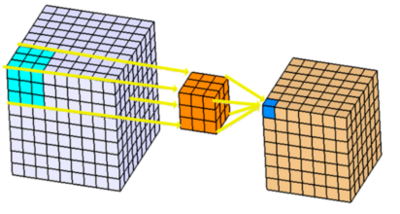


Evaluate the time that build and fit a 3D CNN involved.

In [ ]:
start_CNN = perf_counter()

Import layers and models from TensorFlow Keras.

In [ ]:
from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPooling3D, Dense, Flatten, InputLayer, Dropout
from tensorflow.keras.models import Sequential

We now create our model. The filter for the convolutional layers are really small because the difference between case/controls lies at voxel level.

In [ ]:
def compile_model(shape):
  model = Sequential([

        InputLayer(input_shape=shape),
        Conv3D(6, (4,4,4), strides=2, activation = 'relu'),
        BatchNormalization(),
        MaxPooling3D((2,2,2), strides=(2,2,2)),
        Conv3D(8, (3,3,3),strides=2, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.5),
        MaxPooling3D((2,2,2), strides=(2,2,2)),
        Conv3D(16, (3,3,3),strides=1, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.7),
        MaxPooling3D((2,2,2), strides=1, padding='same'),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')

  ])
  
  return model

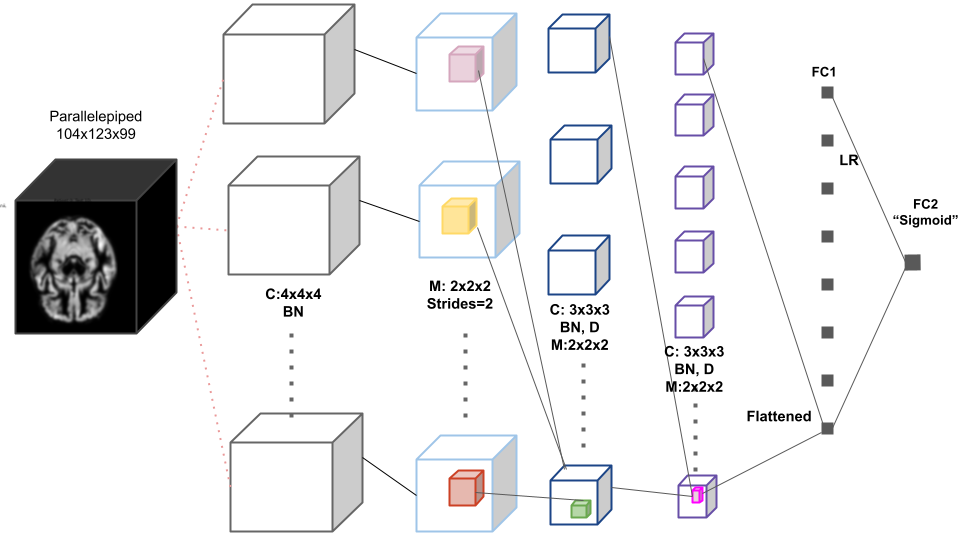

**Convolutional layers (Conv3D)** computes the output of neurons that are connected to local regions or receptive fields in the input, each computing a dot product between their weights and a small receptive field connected to in the input volume. Each computation leads to extraction of a feature map from the input image. 

The objective of the **Max Pooling layers (MaxPooling 3D)**, following the Convolutional layers, is to get an input representation by reducing its dimensions, which helps in reducing overfitting. With this technique the highest pixel value is selected from a region depending on its size.

In order to accelerate the convergence speed and improve the generalization ability of the deep feature fusion network, **batch normalization (BatchNormalization)** is introduced and in the implementation and can be inserted anywhere in the network like a normal computation layer.
Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

Also, **Dropout layers (Dropout)** are introduced to reduce the chances of overfitting randomly setting input units to 0 with a frequency of rate at each step during training time.

The objective of the two **fully connected layers (Dense)** is to flatten the features that are learned by convolutional layers and combine all the features. It passes the flattened output to the 1 neuron output layer where a sigmoid classifier is used to predict the input class label.

Our objective is to distinguish AD class to CTRL class, so we used a binary classification task.

Let's visualize the layers created in the above step using the summary function. This will shows the number of parameters (weights and biases) in each layer and also the total parameters in the model.

In [ ]:
shape = (104,123,99,1)
model = compile_model(shape)
model.summary()

After the model is created, it is compiled using the Adam optimizer.

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

To train the model with the train dataset a Keras'fit() function is used. 

The model trains for 100 epochs. The fit() function will return a history object, that give us information about loss, validation loss, accuracy and validation accuracy. 

This is reported in function **fit_model** below.

First, is importat to notice that splitting 233 samples with a validation split of 0.2 means thata we train our network on approximatively 186 samples.
We have to select the best batch_size value to better improve the classification. Batch size refers to the number of training examples utilized in one iteration. The batch size can be one of three options:

1. batch mode: where the batch size is equal to the total dataset thus making the iteration and epoch values equivalent
2. mini-batch mode: where the batch size is greater than one but less than the total dataset size. Usually, a number that can be divided into the total dataset size.
3. stochastic mode: where the batch size is equal to one. Therefore the gradient and the neural network parameters are updated after each sample.

186 is divisible for 1, 2, 3, 6, 31, 62, 93, 186.

We save each model as "model_*epochs*_*batchsize*.hdf5", and reports all the confusion matrix and ROC AUC everyone in the last section **Results** for the best performances, so batch size = 1, 2, 3, 6, 31.

Set the batch size.

In [ ]:
btc_s = 31

In [ ]:
def fit_model(model, btc_s, train_x, train_y, test_x, test_y):
  history = model.fit(train_x, train_y, validation_split=0.2, epochs=100, batch_size = btc_s)
  score_train = model.evaluate(train_x, train_y, verbose=0)
  print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')
  score_test = model.evaluate(test_x, test_y, verbose=0)
  print(f'Test loss: {score_test[0]} / Test accuracy: {score_test[1]}')
  plt.figure('loss')
  plt.title('Loss and Val_Loss vs epochs = {m}/100'.format(m = len(history.history['loss']) ))
  plt.plot(history.history['loss'], label ='loss')
  plt.plot(history.history['val_loss'], label ='val_loss')
  plt.grid()
  plt.legend()
  plt.show()
  plt.figure('acc')
  plt.title('Accuracy and val_accuracy vs epochs = {m}/100'.format(m = len(history.history['loss']) ))
  plt.plot(history.history['accuracy'], label ='accuracy')
  plt.plot(history.history['val_accuracy'], label ='val_accuracy')
  plt.legend()
  plt.grid()
  plt.show()
  return history, score_train, score_test

In [ ]:
history, score_train, score_test = fit_model(model, btc_s, images_train_r, labels_train, images_test_r, labels_test)

Save the model

In [ ]:
#model.save('/gdrive/MyDrive/AD_CTRL/model_cnn/ModelTrain_{epc}_{btc}.hdf5'.format(epc = len(history.history['loss']), btc=btc_s))

Elapsed time of 3D CNN is reported above.

In [ ]:
time_CNN = perf_counter()-start_CNN
print(time_CNN)

#ROC AUC and Confusion Matrix in Stratified K-fold

Now valutate the performance of our model with AUC and Confusion Matrix, using the Stratified K-fold cross validation, with K=5, and visualize that perfomances in time.

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

Each row of the confusion matrix represents the instances in an actual class, while each column represents the instances in a predicted class.

Splitting 100 samples with a 5 fold means that use our network prediction on 20 samples at time.

In [ ]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [ ]:
start_k_fold = perf_counter()

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
n_splits = 5
cvs = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=1, random_state=42)

In [ ]:
def roc_cv(x_in, y_in, classifier, cvs, enable):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)#Needed for roc curve
    fig, axs = plt.subplots()
    #Here I calcoulate a lot of roc and append it to the list of resoults
    for train, test in cvs.split(x_in, y_in):
      if enable==True:
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        classifier.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
        classifier.fit(x_in[train], y_in[train], validation_split = 0.1, batch_size=6, epochs=100, callbacks=[callback])#Take train of the inputs and fit the model
      probs= classifier.predict(x_in[test])
      fpr, tpr, _ = roc_curve(y_in[test], probs)
      interp_tpr = np.interp(mean_fpr, fpr, tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(auc(fpr, tpr))
    #Plotting the base option
    axs.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Coin Flip', alpha=.8)
    #Calculate mean and std
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    axs.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = {:.2f} $\pm$ {:.2f})'.format(mean_auc,
                                                                 std_auc),
            lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    axs.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Cross-Validation ROC of 3D CNN, k-FoldCV')
    plt.legend(loc="lower right")
    plt.show()
    
    return fig, axs

In [ ]:
roc = roc_cv(images_test_r, labels_test, model, cvs, False)

In [ ]:
def cm_cv(classifier, x_in, y_in, cvs):
  score = []
  confusio = []
  for train, test in cvs.split(x_in, y_in):
    score.append(classifier.evaluate(x_in[test], y_in[test], verbose=0)[1])
    probs= classifier.predict(x_in[test])
    preds = np.round(probs)
    preds_y = []
    for i in range (len(preds)):
      preds_y.extend(preds[i])
    preds_y = np.array(preds_y, dtype='int')
    correct = np.where(preds_y==y_in[test])[0]
    print("Found %d correct labels" % len(correct))
    from sklearn.metrics import confusion_matrix
    confusio.append(confusion_matrix(y_in[test], preds_y, labels=[0,1]).ravel())
  scores = np.array(score)
  conf = np.array(confusio)
  ratio_m = np.mean(conf, axis = 0)
  ratio_std = np.std(conf, axis = 0)
  plt.figure('CM')
  plt.title('3D CNN Confusion Matrix')
  print(u'Accuracy = {mean} \u00B1 {std}'.format(mean=np.mean(scores), std = np.std(scores)))
  print(u'TN = {TN} \u00B1 {sTN}'.format(TN=ratio_m[0], sTN=ratio_std[0]))
  print(u'FP = {FP} \u00B1 {sFP}'.format(FP=ratio_m[1], sFP=ratio_std[1]))
  print(u'FN = {FN} \u00B1 {sFN}'.format(FN=ratio_m[2], sFN=ratio_std[2]))
  print(u'TP = {TP} \u00B1 {sTP}'.format(TP=ratio_m[3], sTP=ratio_std[3]))
  sn.heatmap(ratio_m.reshape(2,2), annot=True, xticklabels = ['CTRL','AD'], yticklabels = ['CTRL', 'AD'])
  plt.show()
  return scores

In [ ]:
cm = cm_cv(model, images_test_r, labels_test, cvs)

In [ ]:
time_k_fold = perf_counter()
print(time_k_fold-start_k_fold)

#MMSE vs model prediction

Another way of view the model ability to distinguish AD/CTRL is to compare MMSE to the model prediction.

MMSE value is availabe in *AD_CTRL_metadata.csv* mentioned in the Introduction.

The Mini–Mental State Examination (MMSE) or Folstein test is a 30-point questionnaire that is used extensively in clinical and research settings to measure cognitive impairment. It is commonly used in medicine and allied health to screen for dementia. 

Administration of the test takes between 5 and 10 minutes and examines functions including registration (repeating named prompts), attention and calculation, recall, language, ability to follow simple commands and orientation.

Spearman's rank correlation test was used to determine the relationships between MMSE total score with prediction, in statistics, Spearman's rank correlation coefficient or Spearman's $\rho$, is a nonparametric measure of rank correlation (statistical dependence between the rankings of two variables). It assesses how well the relationship between two variables can be described using a monotonic function.

The Spearman correlation between two variables is equal to the Pearson correlation between the rank values of those two variables; while Pearson's correlation assesses linear relationships, Spearman's correlation assesses monotonic relationships (whether linear or not). If there are no repeated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other.

Intuitively, the Spearman correlation between two variables will be high when observations have a similar (or identical for a correlation of 1) rank (i.e. relative position label of the observations within the variable: 1st, 2nd, 3rd, etc.) between the two variables, and low when observations have a dissimilar (or fully opposed for a correlation of −1) rank between the two variables.

In [ ]:
df = pd.read_table('/gdrive/MyDrive/AD_CTRL/AD_CTRL_metadata.csv')

def plot_MMSE_Prediction(test_names, X, classifier):
  MMSE = []
  AD = []
  for j in (test_names):
    for i,v in enumerate(df['ID'].values): 
      if v + '.' in j:
        MMSE.append(df['MMSE'].values[i])
        if 'AD' in v:
          AD.append(True)
        else:
          AD.append(False)
  #Helps to understand how to convert names in the table df with those of the split "test_names" vector in order to take MMSE and compares them
  AD = np.array(AD)
  MMSE = np.array(MMSE)
  distances = classifier.predict(X)
  plt.figure()
  plt.scatter(MMSE[AD == True], distances[AD == True],facecolors='none', edgecolors='g')
  plt.scatter(MMSE[AD == False], distances[AD == False],facecolors='none', edgecolors='b')
  plt.xlabel('MMSE')
  plt.ylabel('Model predict')
  plt.title('Distribution of subject')
  plt.legend(['AD', 'CTRL'],loc="upper left")
  plt.grid()
  from scipy.stats import spearmanr
  spr_rank = spearmanr(MMSE,distances)
  print(spr_rank)
  print(type(spr_rank))

In [ ]:
MMSE = plot_MMSE_Prediction(names_test, images_test_r, model)

In [ ]:
print('Total elapsed time: {time}'.format(time=perf_counter()-start))

#Results

Show confusion matrix, ROC AUC, k-Fold

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
def show_model(model, train_x, train_y, test_x, test_y):
  score_train = model.evaluate(train_x, train_y, verbose=0)
  print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')
  score_test = model.evaluate(test_x, test_y, verbose=0)
  print(f'Test loss: {score_test[0]} / Test accuracy: {score_test[1]}')
  plt.figure('loss')
  plt.title('Loss and Val_Loss vs epochs = {m}/100'.format(m = len(history.history['loss']) ))
  plt.plot(history.history['loss'], label ='loss')
  plt.plot(history.history['val_loss'], label ='val_loss')
  plt.grid()
  plt.legend()
  plt.show()
  plt.figure('acc')
  plt.title('Accuracy and val_accuracy vs epochs = {m}/100'.format(m = len(history.history['loss']) ))
  plt.plot(history.history['accuracy'], label ='accuracy')
  plt.plot(history.history['val_accuracy'], label ='val_accuracy')
  plt.legend()
  plt.grid()
  plt.show()
  return score_train, score_test

##Stochastic batch mode, Batch mode =1 

In [ ]:
model_bts1 = load_model('/gdrive/MyDrive/AD_CTRL/model_cnn/ModelTrain_100_1.hdf5')

In [ ]:
score_train, score_test = show_model(model_bts1, images_train_r, labels_train, images_test_r, labels_test)

In [ ]:
roc = roc_cv(images_test_r, labels_test, model_bts1, cvs, False)

In [ ]:
cm = cm_cv(model_bts1, images_test_r, labels_test, cvs)

In [ ]:
MMSE = plot_MMSE_Prediction(names_test, images_test_r, model_bts1)

## Mini batch mode, Batch size = 2

In [ ]:
model_bts2 = load_model('/gdrive/MyDrive/AD_CTRL/model_cnn/ModelTrain_100_2.hdf5')

In [ ]:
score_train, score_test = show_model(model_bts2, images_train_r, labels_train, images_test_r, labels_test)

In [ ]:
roc = roc_cv(images_test_r, labels_test, model_bts2, cvs, False)

In [ ]:
cm = cm_cv(model_bts2, images_test_r, labels_test, cvs)

In [ ]:
MMSE = plot_MMSE_Prediction(names_test, images_test_r, model_bts2)

## Mini batch mode, Batch size = 3

In [ ]:
model_bts3 = load_model('/gdrive/MyDrive/AD_CTRL/model_cnn/ModelTrain_100_3.hdf5')

In [ ]:
score_train, score_test = show_model(model_bts3, images_train_r, labels_train, images_test_r, labels_test)

In [ ]:
roc = roc_cv(images_test_r, labels_test, model_bts3, cvs, False)

In [ ]:
cm = cm_cv(model_bts3, images_test_r, labels_test, cvs)

In [ ]:
MMSE = plot_MMSE_Prediction(names_test, images_test_r, model_bts3)

## Mini batch mode, Batch size = 6


In [ ]:
model_bts6 = load_model('/gdrive/MyDrive/AD_CTRL/model_cnn/ModelTrain_100_6.hdf5')

In [ ]:
score_train, score_test = show_model(model_bts6, images_train_r, labels_train, images_test_r, labels_test)

In [ ]:
roc = roc_cv(images_test_r, labels_test, model_bts6, cvs, False)

In [ ]:
cm = cm_cv(model_bts6, images_test_r, labels_test, cvs)

In [ ]:
MMSE = plot_MMSE_Prediction(names_test, images_test_r, model_bts6)

## Mini batch mode, Batch size = 31

In [ ]:
model_bts31 = load_model('/gdrive/MyDrive/AD_CTRL/model_cnn/ModelTrain_100_31.hdf5')

In [ ]:
score_train, score_test = show_model(model_bts31, images_train_r, labels_train, images_test_r, labels_test)

In [ ]:
roc = roc_cv(images_test_r, labels_test, model_bts31, cvs, False)

In [ ]:
cm = cm_cv(model_bts31, images_test_r, labels_test, cvs)

In [ ]:
MMSE = plot_MMSE_Prediction(names_test, images_test_r, model_bts31)

#Consideration

Best performance are obtained on batch size = 6, higher batch size comports overfitting.

## Why not use K-fold on train section? (Check the RAM)

In [ ]:
start_k_fold_fit = perf_counter()

In [ ]:
#model_train = compile_model(shape)
#model_train.save('model.hdf5')

In [ ]:
#roc = roc_cv(images_train_r, labels_train, model_train, cvs, True)

In [ ]:
#model_train.save('/gdrive/MyDrive/AD_CTRL/model_cnn/ModelTrainK.hdf5')
#models_train = load_model('/gdrive/MyDrive/AD_CTRL/model_cnn/ModelTrainK.hdf5')

In [ ]:
#roc = roc_cv(images_test_r, labels_test, models_train, cvs, False)

In [ ]:
#cm = cm_cv(models_train, images_test_r, labels_test, cvs)

To fit again the model to the test set samples, it's necessary to load the model weights unfitted.

In [ ]:
from keras.models import load_model
#prediction_model = load_model("model.hdf5")

In [ ]:
#roc = roc_cv(images_test_r, labels_test, prediction_model, cvs, True)

In [ ]:
time_k_fold_fit = perf_counter()

In [ ]:
print(time_k_fold_fit-start_k_fold_fit)